In [20]:
# Data handling and numerical operations
import pandas as pd                                 # Data manipulation and analysis
import numpy as np                                  # Numerical operations
from scipy.stats import sem
# Data visualization
import matplotlib.pyplot as plt                     # Plotting graphs
import seaborn as sns                               # Advanced data visualization

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords                   # Stopwords in text processing
from nltk.stem.porter import PorterStemmer          # Stemming words
import re                                           # Regular expression operations
from wordcloud import WordCloud, STOPWORDS          # Generating word cloud visualizations

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Scikit-learn
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline

# Utility libraries
import chardet                                      # Detecting character encoding
from collections import Counter
from scipy.sparse import hstack                # Handling collections of data

from urllib.parse import urlparse                   # parsing base url values
%matplotlib inline
# Downloading NLTK resources
# nltk.download('stopwords')

In [21]:
df = pd.read_feather("../Data/Data145.feather")

In [22]:
df.head(10)

,text,sentiment,base_url
0,video offic mind busi david solomon tell gs in...,0,twitter.com
1,price lumber lb f sinc hit ytd high maci turna...,0,twitter.com
2,say american dream dead,-1,buff.ly
3,barri silbert extrem optimist bitcoin predict ...,1,twitter.com
4,satellit avoid attack space junk circl earth paid,-1,on.forbes.com
5,david butler favorit fang stock realmoneysod a...,0,bit.ly
6,miss convo one favorit thinker,0,twitter.com
7,u intellig document nelson mandela made public,0,reut.rs
8,senat want emerg alert go netflix spotifi etc,1,tcrn.ch
9,hedg fund manag marc larsi say bitcoin k possibl,0,on.mktw.net


In [23]:
X = df[['text', 'base_url']]
Y = df['sentiment']

In [24]:
stop_words_appened=stopwords.words('english').append(['rt', 'ep'])

In [25]:

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_text = tfidf_vectorizer_text.fit_transform(X_train['text'])
X_test_tfidf_text = tfidf_vectorizer_text.transform(X_test['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_url = tfidf_vectorizer_url.fit_transform(X_train['base_url'])
X_test_tfidf_url = tfidf_vectorizer_url.transform(X_test['base_url'])

# Concatenating the TF-IDF matrices horizontally
X_train_tfidf_combined = hstack([X_train_tfidf_text, X_train_tfidf_url])
X_test_tfidf_combined = hstack([X_test_tfidf_text, X_test_tfidf_url])


In [26]:
# Creating and training the tree model
tree_tf = tree.DecisionTreeClassifier(random_state=40, class_weight='balanced')
tree_tf.fit(X_train_tfidf_combined, y_train)

# Predicting on the test set
y_pred = tree_tf.predict(X_test_tfidf_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8978590544157002
              precision    recall  f1-score   support

          -1       0.71      0.74      0.72       491
           0       0.94      0.93      0.93      2587
           1       0.89      0.89      0.89      1406

    accuracy                           0.90      4484
   macro avg       0.85      0.86      0.85      4484
weighted avg       0.90      0.90      0.90      4484



In [27]:
# confusion matrix
cm_tf = confusion_matrix(y_test, y_pred)
cm_tf

array([[ 365,   62,   64],
       [  95, 2407,   85],
       [  56,   96, 1254]])

In [28]:
# printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

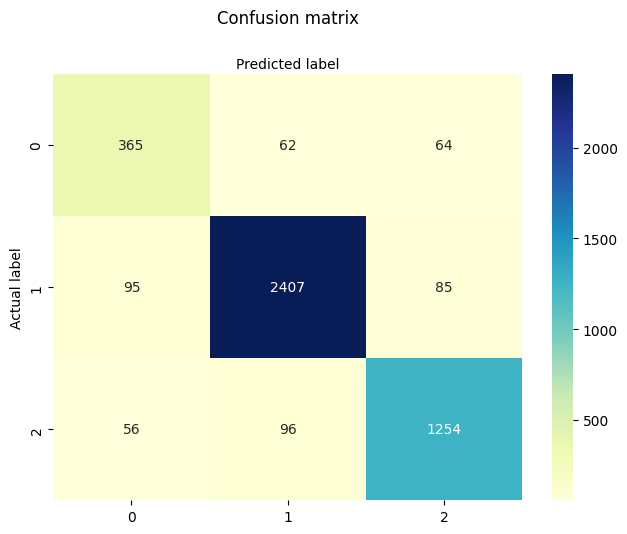

In [29]:
# plotting confusion matrix
plot_conf_mat(cm_tf)

In [30]:
# ROC with one vs rest multiclass
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(4484, 3)

In [31]:
# changing labels to binary data
label_binarizer.transform([-1])

array([[1, 0, 0]])

In [32]:
# ROC curve showing an individual class
class_of_interest = 0 # neutral sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
y_score = tree_tf.predict_proba(X_test_tfidf_combined)
class_id

1

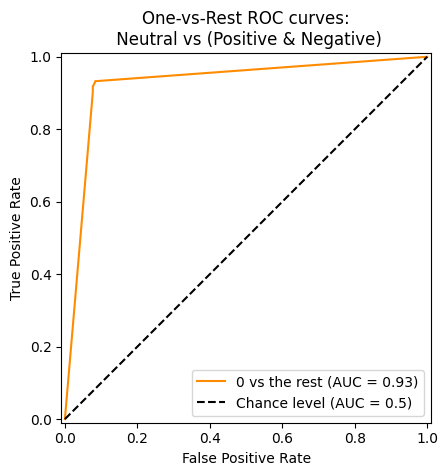

In [33]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Neutral vs (Positive & Negative)",
)

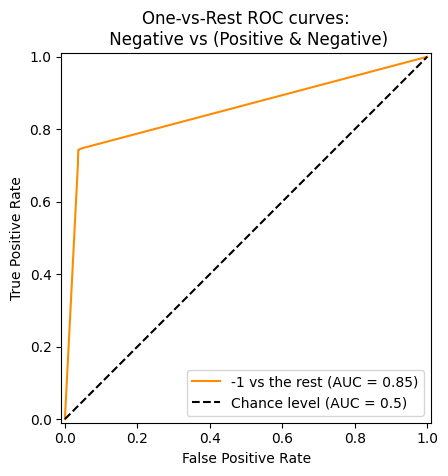

In [34]:
# for negative sentiments
# ROC curve showing an individual class
class_of_interest = -1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Negative vs (Positive & Negative)",
)

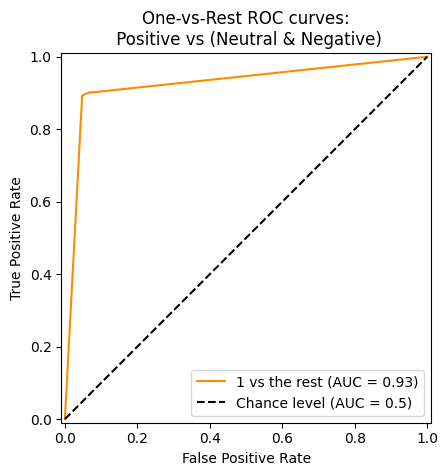

In [35]:
# for positive sentiments
# ROC curve showing an individual class
class_of_interest = 1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Positive vs (Neutral & Negative)",
)

## Roc Micro Averaged for TFIDF
##### Micro-averaging aggregates the contributions from all the classes (using numpy.ravel) to compute the average metrics. In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferred.

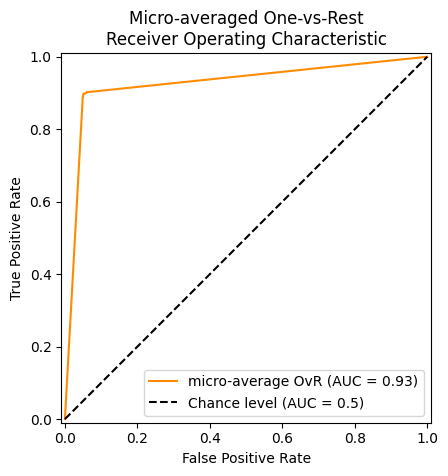

In [36]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [37]:
# computing ROC-AUC score
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)
print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr}")

Micro-averaged One-vs-Rest ROC AUC score:
0.9255214894309511


## Bag of word Vectorizer

In [38]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)

# Fitting and transforming the text training set
X_train_bow_text = bow_vectorizer_text.fit_transform(X_train['text'])
X_test_bow_text = bow_vectorizer_text.transform(X_test['text'])
bow_vectorizer_url = CountVectorizer(max_features=1000)

# Fitting and transforming the url training set
X_train_bow_url = bow_vectorizer_url.fit_transform(X_train['base_url'])
X_test_bow_url = bow_vectorizer_url.transform(X_test['base_url'])
X_train_bow_combined = hstack([X_train_bow_text, X_train_bow_url])
X_test_bow_combined = hstack([X_test_bow_text, X_test_bow_url])


In [39]:
# Creating and training the tree model
tree_model = tree.DecisionTreeClassifier(random_state=40)
tree_model.fit(X_train_bow_combined, y_train)

# Predicting on the test set
y_pred = tree_model.predict(X_test_bow_combined)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9090098126672613
              precision    recall  f1-score   support

          -1       0.77      0.74      0.75       491
           0       0.95      0.94      0.94      2587
           1       0.89      0.91      0.90      1406

    accuracy                           0.91      4484
   macro avg       0.87      0.86      0.87      4484
weighted avg       0.91      0.91      0.91      4484



In [40]:
# confusion matrix
cm_bow = confusion_matrix(y_test, y_pred)
cm_bow

array([[ 364,   62,   65],
       [  52, 2437,   98],
       [  58,   73, 1275]])

In [41]:
# printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

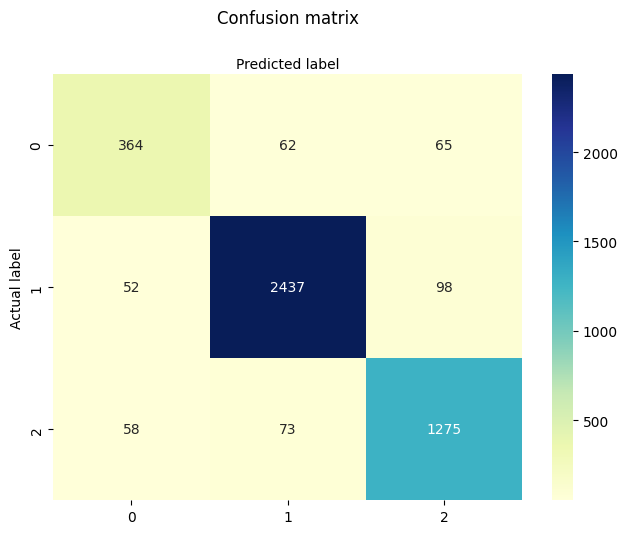

In [42]:
# plotting confusion matrix
plot_conf_mat(cm_bow)

In [43]:
# ROC with one vs rest multiclass
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(4484, 3)

In [44]:
label_binarizer.transform([-1])

array([[1, 0, 0]])

In [45]:
# ROC curve showing an individual class
class_of_interest = 0 # neutral sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
y_score = tree_tf.predict_proba(X_test_bow_combined)
class_id

1

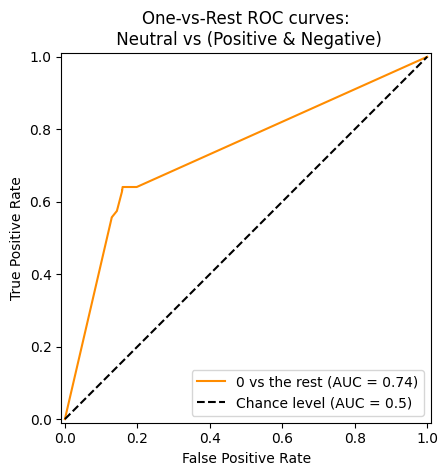

In [46]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Neutral vs (Positive & Negative)",
)

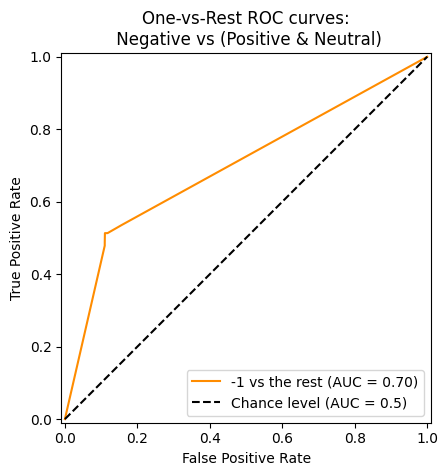

In [47]:
# for negative sentiments
# ROC curve showing an individual class
class_of_interest = -1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Negative vs (Positive & Neutral)",
)

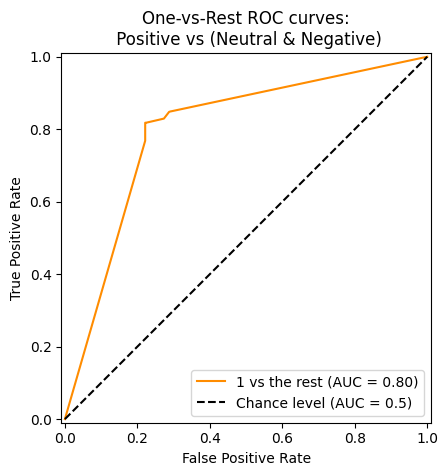

In [48]:
# for positive sentiments
# ROC curve showing an individual class
class_of_interest = 1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Positive vs (Neutral & Negative)",
)

## Roc Micro Averaged for BOW

##### Micro-averaging aggregates the contributions from all the classes (using numpy.ravel) to compute the average metrics. In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferred.

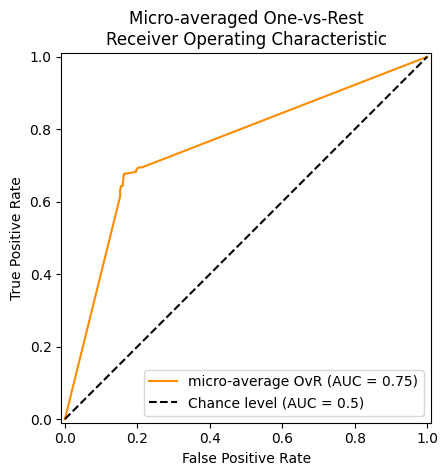

In [49]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [50]:
# computing ROC-AUC score
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)
print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr}")

Micro-averaged One-vs-Rest ROC AUC score:
0.7547931474661419


# K-Fold Cross Validation

In [54]:

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_text = tfidf_vectorizer_text.fit_transform(X['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_url = tfidf_vectorizer_url.fit_transform(X['base_url'])

# Concatenating the TF-IDF matrices horizontally
X_tfidf_combined = hstack([X_tfidf_text, X_tfidf_url])

In [55]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)
X_bow_text = bow_vectorizer_text.fit_transform(X['text'])

bow_vectorizer_url = CountVectorizer(max_features=1000)
X_bow_url = bow_vectorizer_url.fit_transform(X['base_url'])

X_bow_combined = hstack([X_bow_text, X_bow_url])

In [56]:
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
	# prepare the cross-validation procedure
    tree1 = tree.DecisionTreeClassifier(random_state=40)
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    # evaluate model
    scores = cross_val_score(tree1, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

>1 mean=0.9133 se=0.002
>2 mean=0.9133 se=0.001
>3 mean=0.9133 se=0.001
>4 mean=0.9129 se=0.001
>5 mean=0.9125 se=0.001
>6 mean=0.9128 se=0.001
>7 mean=0.9126 se=0.001
>8 mean=0.9126 se=0.001
>9 mean=0.9124 se=0.001


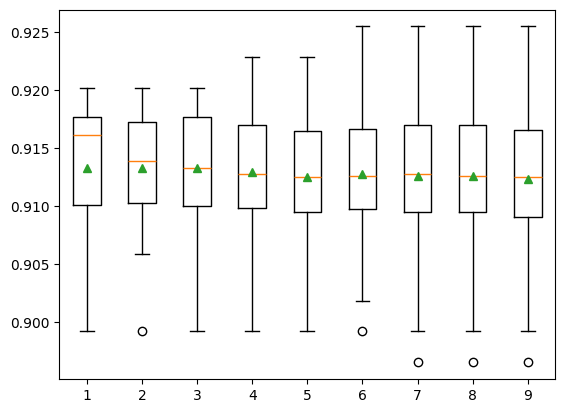

In [57]:
repeats = range(1,10)
results = list()

for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_tfidf_combined, Y, r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)
# plot the results
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

>1 mean=0.9147 se=0.002
>2 mean=0.9146 se=0.001
>3 mean=0.9139 se=0.001
>4 mean=0.9135 se=0.001
>5 mean=0.9139 se=0.001
>6 mean=0.9140 se=0.001
>7 mean=0.9138 se=0.001
>8 mean=0.9139 se=0.001
>9 mean=0.9139 se=0.001


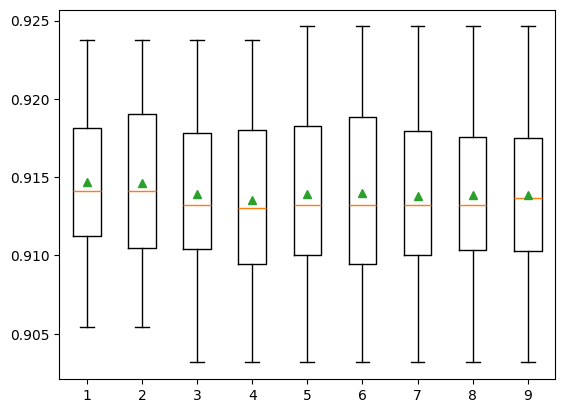

In [58]:
repeats = range(1,10)
results = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_bow_combined, Y, r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)
# plot the results
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

## Hyper parameter tunning of Decision Trees

## Grid Search

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
tree_gdcv = tree.DecisionTreeClassifier(random_state=43)

params = {'max_depth':[15,30,60,90],
          'min_samples_leaf':[2,3,5,10,15],
          'min_samples_split':[3,5,8,10,12],
          'criterion':['gini','entropy']}
GS = GridSearchCV(estimator=tree_gdcv,param_grid=params,cv=10,n_jobs=-1, verbose=True, scoring='accuracy')

In [61]:
GS.fit(X_bow_combined, Y)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=43),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [15, 30, 60, 90],
                         'min_samples_leaf': [2, 3, 5, 10, 15],
                         'min_samples_split': [3, 5, 8, 10, 12]},
             scoring='accuracy', verbose=True)

In [62]:
print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 60, 'min_samples_leaf': 3, 'min_samples_split': 10}

Best Score: 0.9076506641095058


## RandomizedSearch CV

In [63]:
from sklearn.model_selection import RandomizedSearchCV

In [64]:
tree_RS = tree.DecisionTreeClassifier(random_state=43)

params = {'max_depth':[3,5,7,10,15,30, 60, 120],
          'min_samples_leaf':[3,5,10,15,20],
          'min_samples_split':[8,10,12,18,20,16],
          'criterion':['gini','entropy']}
RS = RandomizedSearchCV(estimator=tree_RS,param_distributions=params,cv=10,n_iter=300,n_jobs=-1, verbose=True, scoring='accuracy')

In [65]:
RS.fit(X_bow_combined, Y)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=43),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7, 10, 15, 30, 60,
                                                      120],
                                        'min_samples_leaf': [3, 5, 10, 15, 20],
                                        'min_samples_split': [8, 10, 12, 18, 20,
                                                              16]},
                   scoring='accuracy', verbose=True)

In [66]:
print('Best Parameters:',RS.best_params_,end='\n\n')
print('Best Score:',RS.best_score_)

Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 60, 'criterion': 'gini'}

Best Score: 0.9076506641095058
